In [80]:
import pyconll
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def merge_files(locations, new_file):
  files = []
  for loc in locations:
    files += glob.glob(loc)
  res = open(new_file, 'w')
  for file in files:
    with open(file) as fd:
      res.write(fd.read())
  res.close()

In [ ]:
merge_files(['./UD_Hebrew-*/*.conllu'], 'he-ud.conllu')

In [4]:
heb = pyconll.load_from_file('he-ud.conllu')

In [5]:
def all_POS(sentence):
  for token in sentence:
    if token.upos == 'X':
      return False
  return True

def count_words(sentence):
  result = 0
  skip = 0
  for token in sentence:
    if '-' in token.id:
      result += 1
      skip = int(token.id.split('-')[1])
    elif int(token.id) > skip and token.upos != 'PUNCT':
      result += 1
  return result

def count_tokens(sentence):
  result = 0
  for token in sentence:
    if '-' not in token.id:
      result += 1
  return result
  

In [74]:
data = pd.DataFrame([(count_words(sentence), count_tokens(sentence), sentence.text) for sentence in heb if all_POS(sentence)], columns=['words', 'tokens', 'sentence'])

In [ ]:
ru_data = pd.read_csv(
            "RuSentEval/data/sent_len.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )

In [75]:
count, division = np.histogram(data.words, bins=np.arange(100))
thresholds = np.linspace(0.05, 0.95, num = 7) * sum(count)
threshold_ids = np.searchsorted(np.cumsum(count), thresholds)
data['sent_len'] = data['words'].apply(lambda x : (threshold_ids >= x).sum() - 1)
sent_len_he = data[(data['sent_len'] >= 0) & (data['sent_len'] < 6)].drop(['words', 'tokens'], axis=1)

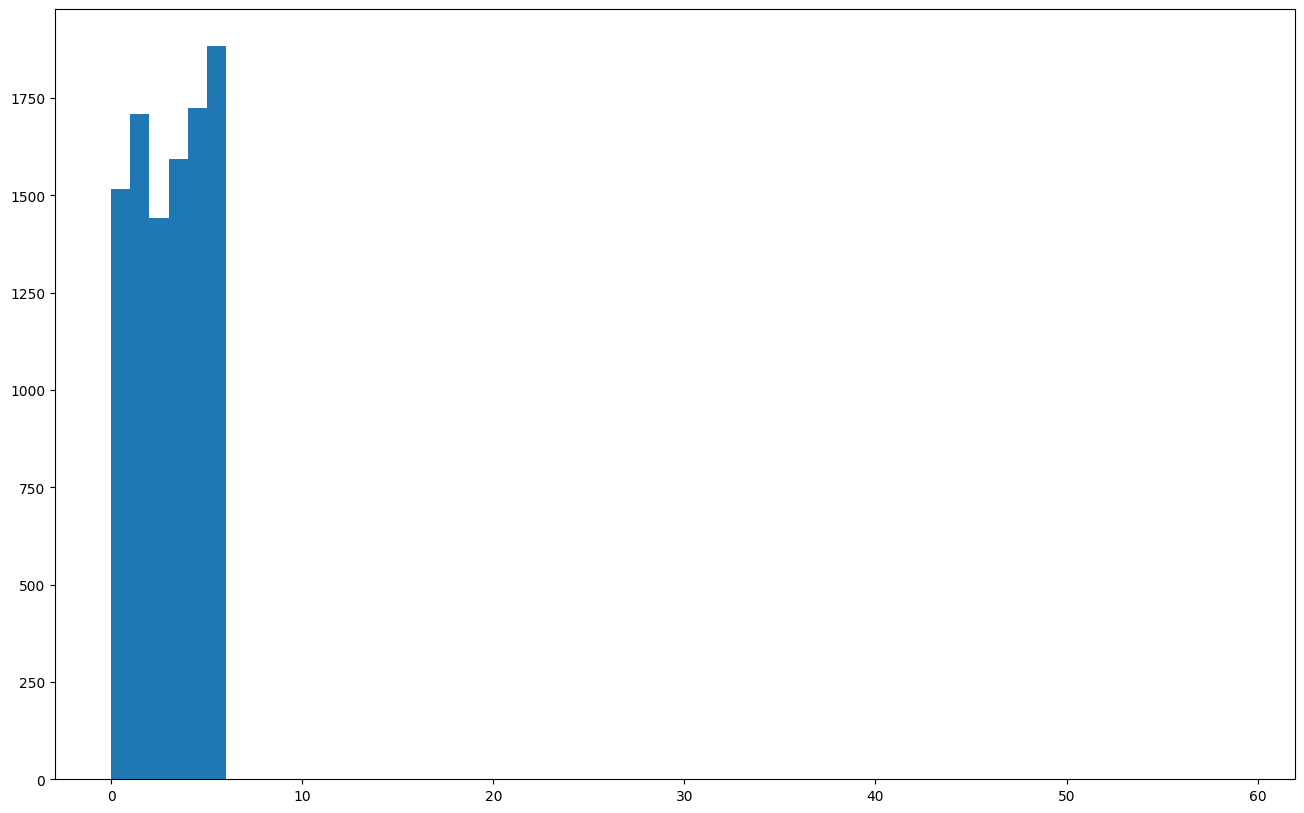

In [8]:
fig = plt.figure(figsize=(16, 10))
plt.hist(sent_len_he.sent_len, bins=np.arange(60))
plt.show()

In [74]:
def add_column_train(data, split_column, val_size, test_size, seed=None):
  res = data.reset_index(drop=True)
  classes = data[split_column].unique()
  train_size = 1 - val_size - test_size
  if seed:
    np.random.seed(seed)
  res['subset'] = ''
  for label in classes:
    ids = res[res[split_column] == label].index
    perm = np.random.permutation(ids)
    train_point = int(np.floor(len(ids) * train_size))
    val_point = int(np.floor(len(ids) * (train_size + val_size)))
    res.loc[perm[:train_point], 'subset'] = 'tr'
    res.loc[perm[train_point:val_point], 'subset'] = 'va'
    res.loc[perm[val_point:], 'subset'] = 'te'
  return res.reset_index(drop=True)

In [78]:
def slice_dataset(data, class_column, target_part=0.1, seed=None):
  result = pd.DataFrame(columns=['subset', 'label', 'sentence'])
  if seed:
    np.random.seed(seed)
  for group_val in data.groupby(class_column).groups.values():
    gp_res = np.random.permutation(group_val)[:int(np.floor(len(group_val) * target_part))]
    result = pd.concat([result, data.loc[gp_res]])
  result.reset_index(inplace=True, drop=True)
  return add_column_train(result, 'label', val_size=0.1, test_size=0.1)

In [80]:
ru_data = pd.read_csv(
            "RuSentEval/data/sent_len.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
ru_data_sliced = slice_dataset(ru_data, 'label', seed=42)
ru_data_sliced.to_csv('data/ru/sent_len.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [79]:
sent_len_splited = add_column_train(sent_len_he, 'sent_len', 0.1, 0.1, 42).drop(['index'], axis=1)

In [81]:
en_data = pd.read_csv(
            "SentEval/data/probing/sentence_length.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
en_data_sliced = slice_dataset(en_data, 'label', seed=42)
en_data_sliced.to_csv('data/en/sent_len.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [5]:
def get_words_frequency(ud_data, upos):
  result = {}
  for sentence in ud_data:
    for token in sentence:
      if token.upos == upos:
        if token.lemma not in result:
          result[token.lemma] = 0
        result[token.lemma] += 1
  return result

In [6]:
nn_frq_he = get_words_frequency(heb, 'NOUN')

(array([235., 221., 150., 162., 116., 114., 104.,  81.,  53.,  47.,  37.,
         32.,  14.,  11.,   8.,   5.,   0.,   0.,   1.]),
 array([  10.        ,   12.74274986,   16.23776739,   20.69138081,
          26.36650899,   33.59818286,   42.81332399,   54.55594781,
          69.51927962,   88.58667904,  112.88378917,  143.84498883,
         183.29807108,  233.57214691,  297.63514416,  379.26901907,
         483.29302386,  615.84821107,  784.75997035, 1000.        ]),
 <BarContainer object of 19 artists>)

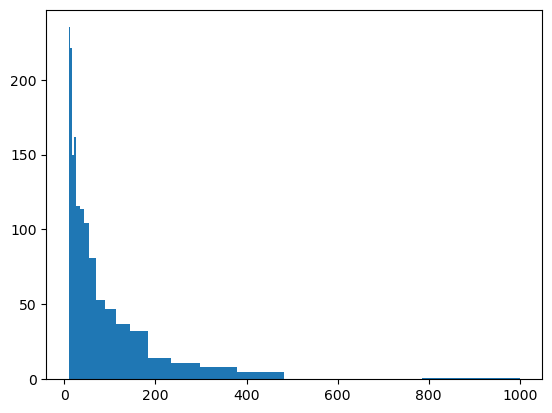

In [10]:
plt.hist(list(nn_frq_he.values()), bins=np.logspace(1, 3, 20))

In [ ]:
plt.hist(nn_frq_he.values(), bins=np.arange(100))
plt.show()

In [89]:
srt_nn = sorted(nn_frq_he.items(), key=lambda x: (-x[1], x[0]))

In [ ]:
srt_nn

In [ ]:
""" 
https://stackoverflow.com/a/46564234/19784783 
"""

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#example text text = 'What can I say about this place. The staff of these restaurants is nice and the eggplant is not bad'

class Splitter(object):
    """
    split the document into sentences and tokenize each sentence
    """
    def __init__(self):
        # self.splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self,sentences):
        """
        out : ['What', 'can', 'I', 'say', 'about', 'this', 'place', '.']
        """
        # split into single sentence
        # sentences = self.splitter.tokenize(text)
        # tokenization in each sentences
        tokens = [self.tokenizer.tokenize(sent) for sent in sentences]
        return tokens


class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def pos_tag(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
        pos_tokens = [nltk.pos_tag(token) for token in tokens]

        # lemmatization using pos tagg   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
        pos_tokens = [ [(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos] for pos in pos_tokens]
        return pos_tokens

lemmatizer = WordNetLemmatizer()
splitter = Splitter()
lemmatization_using_pos_tagger = LemmatizationWithPOSTagger()
sentences = list(pd.read_csv('SentEval/data/probing/subj_number.txt', sep='\t', names=['subset', 'label', 'sentence'])['sentence'])

#step 1 split document into sentence followed by tokenization
tokens = splitter.split(sentences)

#step 2 lemmatization using pos tagger 
lemma_pos_token = lemmatization_using_pos_tagger.pos_tag(tokens)
print(lemma_pos_token)

In [105]:
en_dct = {}
for sent in lemma_pos_token:
  for token in sent:
    if token[2] == ['NN']:
      if token[1] not in en_dct:
        en_dct[token[1]] = 0
      en_dct[token[1]] += 1

In [113]:
en_nn_stat = np.array(list(en_dct.values()), dtype=int)
print(len(en_nn_stat), ((en_nn_stat <= 5000) & (en_nn_stat >= 100)).sum())

14070 480


In [1]:
len(srt_nn)

NameError: name 'srt_nn' is not defined

In [45]:
def get_tense(sentence):
  root = sentence.to_tree()
  if root.data.upos != 'VERB':
    return 'None'
  if 'Tense' in root.data.feats:
    return list(root.data.feats['Tense'])[0]
  else:
    return 'Pres'

In [93]:
tenses = pd.DataFrame([(get_tense(sentence), count_words(sentence), sentence.text) for sentence in heb if all_POS(sentence)], columns=['tense', 'words', 'sentence'])

In [94]:
tenses_processed = tenses.loc[(tenses['tense'] != 'Fut') & (tenses['words'] >= 4), ['sentence', 'tense']]
tenses_processed.loc[tenses['tense'] == 'None', 'tense'] = 'Pres'

In [96]:
tenses_processed = add_column_train(tenses_processed, 'tense', val_size=0.1, test_size=0.1, seed=42)

In [99]:
tenses_processed.to_csv('data/he/past_present.txt', sep='\t', index=False, header=False, columns=['subset', 'tense', 'sentence'])

In [100]:
en_data = pd.read_csv(
            "SentEval/data/probing/past_present.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
en_data_sliced = slice_dataset(en_data, 'label', seed=42)
en_data_sliced.to_csv('data/en/past_present.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [54]:
def bigram_shift(sentence):
  if np.random.randint(2):
    wrds_ids = []
    last = -1
    for i in range(len(sentence)):
      nid = int(sentence[i].id.split('-')[-1])
      if nid > last:
        last = nid
        if sentence[i].upos != 'PUNCT':
          wrds_ids.append(i)
    ids_to_change = np.random.randint(len(wrds_ids) - 1)
    tokens_to_change = [wrds_ids[ids_to_change], wrds_ids[ids_to_change + 1]]
    result = ""
    last = -1
    for i in range(len(sentence)):
      nid = int(sentence[i].id.split('-')[-1])
      if nid > last:
        last = nid
        if sentence[i].upos != 'PUNCT':
          wrds_ids.append(i)
        to_add = i
        if i in tokens_to_change:
          to_add = sum(tokens_to_change) - i
        result += sentence[to_add].form
        if not ('SpaceAfter' in sentence[i].misc and sentence[i].misc['SpaceAfter'] == set(['No'])) and sentence[i].form != '.':
          result += ' '
      
    return ('I', result)
  return ('O', sentence.text)

In [7]:
len(heb[0])

18

In [56]:
bshift_processed = pd.DataFrame([bigram_shift(sentence) for sentence in heb if len(sentence.text.split()) > 3 and all_POS(sentence)], columns=['swapped', 'sentence'])

In [60]:
bshift_processed = add_column_train(bshift_processed, 'swapped', val_size=0.1, test_size=0.1, seed=42)

In [61]:
bshift_processed.to_csv('data/he/bigram_shift.txt', sep='\t', index=False, header=False, columns=['subset', 'swapped', 'sentence'])

In [62]:
en_data = pd.read_csv(
            "SentEval/data/probing/bigram_shift.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
en_data_sliced = slice_dataset(en_data, 'label', seed=42)
en_data_sliced.to_csv('data/en/bigram_shift.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [14]:
kek = np.array(list(nn_frq_he.values()))

In [17]:
((kek > 100) & (kek < 500)).sum()

126

In [52]:
def subj_number(sentence):
  root = sentence.to_tree()
  for chld in root:
    if 'subj' in chld.data.deprel and chld.data.upos == 'NOUN':
      num = 'Sing'
      if 'Number' in chld.data.feats:
        num = list(chld.data.feats['Number'])[0]
      return (chld.data.lemma, num, nn_frq_he[chld.data.lemma], sentence.text)
  return (None, None, None, None)

In [72]:
def balance_dataset(dataset, label_col, seed=None):
  if seed:
    np.random.seed(seed)
  to_size = min(dataset.groupby(label_col).size().values)
  res_indicies = np.array([])
  for label in dataset[label_col].unique():
    label_rows = np.where(dataset[label_col] == label)[0]
    np.random.shuffle(label_rows)
    res_indicies = np.concatenate([res_indicies, label_rows[:to_size]])
  return dataset.loc[res_indicies,:].reset_index(drop=True)

In [53]:
subjnum_processed = pd.DataFrame([subj_number(sentence) for sentence in heb if len(sentence.text.split()) > 3 and all_POS(sentence)], columns=['lemma', 'number', 'freq', 'sentence'])

In [56]:
subjnum_processed.dropna(inplace=True)
subjnum_processed.drop(subjnum_processed[(subjnum_processed['freq'] < 50) | (subjnum_processed['freq'] > 500)].index, inplace=True)
subjnum_processed.drop(subjnum_processed[(subjnum_processed['number'] == 'Dual')].index, inplace=True)
subjnum_processed.reset_index(inplace=True, drop=True)
subjnum_processed = balance_dataset(subjnum_processed, 'number', seed=42)
subjnum_processed = add_column_train(subjnum_processed, 'number', 0.1, 0.1)

In [105]:
subjnum_processed.to_csv('data/he/subj_number.txt', sep='\t', index=False, header=False, columns=['subset', 'number', 'sentence'])

In [108]:
en_data = pd.read_csv(
            "SentEval/data/probing/subj_number.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
en_data_sliced = slice_dataset(en_data, 'label', target_part=0.02, seed=42)
en_data_sliced.to_csv('data/en/subj_number.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [109]:
def coordination_inversion(sentence):
  cnt_cconj = sum([token.upos == 'CCONJ' for token in sentence])
  if cnt_cconj != 1:
    return (None, None)
  if np.random.randint(2):
    fxd = [int(sentence[-1].id)]
    lst_punct_id = -1
    cconj_id = -1
    cconj_index = -1
    
    for i in sentence:
      token = sentence[i]
      if token.upos == 'PUNKT':
        lst_punct_id = int(token.id)
      if token.upos == 'CCONJ':
        cconj_id = int(token.id)
        cconj_index = i
        break
    fxd.append(cconj_id)
    has_punct = (cconj_id - 1 == lst_punct_id)
    cconj_in_compound = (len(sentence[cconj_index - 1].id.split('-')) > 1)
    result = ""
    last = -1
    start = cconj_index + 1
    if cconj_in_compound:
      last_id_in_compound = int(sentence[cconj_index - 1].id.split('-')[1])
      for i in range(cconj_index + 1, last_id_in_compount + 1):
        result += sentence[i].form
      comp_id = cconj_index - 1
      if not ('SpaceAfter' in sentence[comp_id].misc \\
              and sentence[comp_id].misc['SpaceAfter'] == set(['No'])) \\
              and sentence[comp_id].form != '.':
        result += ' '
      start = last_id_in_compound + 1
    for i in range(start, len(sentence) - 1):
      nid = int(sentence[i].id.split('-')[-1])
      if nid > last:
        last = nid
        result += sentence[i].form
        if not ('SpaceAfter' in sentence[i].misc and sentence[i].misc['SpaceAfter'] == set(['No'])) and sentence[i].form != '.':
          result += ' '
    if has_punct:
      
    for i in range(start, len(sentence) - 1):
      nid = int(sentence[i].id.split('-')[-1])
      if nid > last:
        last = nid
        result += sentence[i].form
        if not ('SpaceAfter' in sentence[i].misc and sentence[i].misc['SpaceAfter'] == set(['No'])) and sentence[i].form != '.':
          result += ' '

In [86]:
def coordination_inversion(sentence):
  cnt_cconj = sum([token.upos == 'CCONJ' for token in sentence])
  if cnt_cconj != 1:
    return (None, None, None)
  fxd = [int(sentence[-1].id)]
  lst_comma_id = -1
  cconj_id = -1
  cconj_index = -1

  for i in range(len(sentence)):
    token = sentence[i]
    if token.form == ',':
      lst_comma_id = int(token.id)
    if token.upos == 'CCONJ':
      cconj_id = int(token.id)
      cconj_index = i
      break
  fxd.append(cconj_id)
  has_punct = (cconj_id - 1 == lst_comma_id)
  cconj_in_compound = (len(sentence[cconj_index - 1].id.split('-')) > 1)
  splitter = ' ' + sentence[cconj_index].form
  if has_punct:
    splitter = ',' + splitter
  if not cconj_in_compound:
    splitter += ' '
  parts = sentence.text[:-1].split(splitter)
  if len(parts) < 2:
    return ('-1', sentence.text, sentence[cconj_index].form, 1, 1)
  if len(parts) > 2:
    return ('+1', sentence.text, sentence[cconj_index].form, 1, 1)
  new_sent = parts[1] + splitter + parts[0] + '.'
  ptszs = list(map(len, parts))
  if np.random.randint(2):
    return ('I', new_sent, sentence[cconj_index].form, min(ptszs), max(ptszs))
  return ('O', sentence.text, sentence[cconj_index].form, min(ptszs), max(ptszs))

In [37]:
cnt = 0
for sent in heb:
  res = coordination_inversion(sent)
  if res != (None, None):
#     print(res)
    cnt += 1
    if cnt == 50:
      break

In [87]:
np.random.seed(42)
crd_inv_proc = pd.DataFrame([coordination_inversion(sent) for sent in heb if len(sent.text.split()) > 3 and all_POS(sent)], columns=["label", "sentence", "cconj", 'min', 'max'])

In [88]:
crd_inv_proc.dropna(inplace=True)
crd_inv_proc.drop(crd_inv_proc[(crd_inv_proc['label'] == '+1') | (crd_inv_proc['label'] == '-1')].index, inplace=True)
crd_inv_proc.reset_index(inplace=True, drop=True)

In [90]:
crd_inv_proc['ff'] = crd_inv_proc['max'] / crd_inv_proc['min']

(array([  0.,   0., 908., 584., 409., 282., 228., 136., 131.,  95.,  66.,
         60.,  57.,  37.,  40.,  47.,  27.,  27.,  24.,  20.,  14.,  20.,
         12.,  13.,   8.,   9.,   9.,   9.,   9.,   4.,  12.,   7.,   8.,
         10.,  11.,   6.,   4.,   2.,   4.,   3.,   3.,   3.,   4.,   1.,
          4.,   3.,   5.,   2.,   3.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
        22. , 22.5, 23. , 23.5, 24. , 24.5]),
 <BarContainer object of 49 artists>)

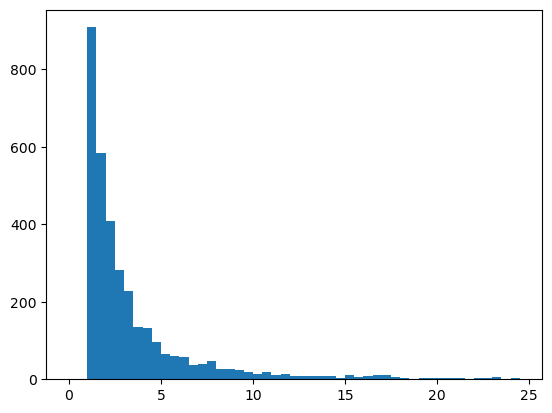

In [94]:
plt.hist(crd_inv_proc['ff'], bins=np.arange(0, 25, 0.5))

In [75]:
crd_inv_proc = add_column_train(crd_inv_proc, 'label', 0.1, 0.1, seed=42)

In [85]:
2978/len(crd_inv_proc)

0.869235259778167

In [83]:
crd_inv_proc.groupby(['cconj']).count()

,label,sentence,subset
cconj,,,
אבל,63,63,63
או,157,157,157
אולם,27,27,27
אילו,3,3,3
איפוא,1,1,1
אך,95,95,95
אלא,50,50,50
אלה,1,1,1
אלמלא,1,1,1


In [76]:
crd_inv_proc.to_csv('data/he/coordination_inversion.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [79]:
en_data = pd.read_csv(
            "SentEval/data/probing/coordination_inversion.txt",
            sep="\t",
            names=("subset", "label", "sentence"),
          )
en_data_sliced = slice_dataset(en_data, 'label', target_part=0.04, seed=42)
en_data_sliced.to_csv('data/en/coordination_inversion.txt', sep='\t', index=False, header=False, columns=['subset', 'label', 'sentence'])

In [118]:
# counting freq of words by POS

heb_freq_by_pos = {}
for sent in heb:
  if all_POS(sent):
    for token in sent:
      if token.upos == None:
        continue
      if token.upos not in heb_freq_by_pos:
        heb_freq_by_pos[token.upos] = {}
      if token.lemma not in heb_freq_by_pos[token.upos]:
        heb_freq_by_pos[token.upos][token.lemma] = 0
      heb_freq_by_pos[token.upos][token.lemma] += 1

In [119]:
pos_freqs = {pos: len([freq for freq in dct.values() if 10 < freq < 100]) for pos, dct in heb_freq_by_pos.items()}

In [120]:
pos_freqs

{'DET': 13,
 'NOUN': 1161,
 'VERB': 445,
 'CCONJ': 7,
 'ADP': 63,
 'PRON': 9,
 'PUNCT': 8,
 'ADJ': 281,
 'ADV': 111,
 'SCONJ': 13,
 'NUM': 119,
 'PROPN': 270,
 'AUX': 6,
 'INTJ': 0,
 'SYM': 3}

In [ ]:
def odd_man_out